### Creation of the SymPortal manuscripts's figures
This notebook will document how the following figures were made: 
1. 'raw seq abundance' (Fig. 3 parts i)
2. 'post-QC' (Fig. 3 parts ii)
3. psbAncr phylogenetic tree
4.  ordination plot

#### 1. 'raw seq abundance' figure
This figure will be created from __.names__ file that was created in [this](https://github.com/didillysquat/fastq_processing/blob/master/create_fastq_for_SP_example.ipynb) process.

__Do imports__

In [1]:
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from Bio import SeqIO
import numpy
import subprocess
import pickle

__Read in the .names file__

In [2]:
with open('/home/humebc/projects/SymPortalMS/making_example_data_set/SP_DEMO_DATA/unzipped/stability.trim.contigs.pcr.names') as f:
    name_file = f.read().splitlines()

__Identify which sequence are clade C and only work with these for the figure: using blastn__

In [3]:
# The first thing we need to do is to work out which of the representative sequences are clade C sequences
# we will use blast to do this.
# We will need the fasta that is associated with the .names file to use as input.

# write out the .ncbirc file pointing towards the ITS2clade.fas
ncbirc = ['[BLAST]', 'BLASTDB={}'.format('/home/humebc/phylogeneticSoftware/ncbi-blast-2.6.0+/ntdbdownload')]
ncbirc_path = '/home/humebc/projects/SymPortalMS/.ncbirc'
with open(ncbirc_path, 'w') as f:
    for item in ncbirc:
        f.write("{}\n".format(item))

# setup the blast
outputpath = '/home/humebc/projects/SymPortalMS/sym_clade.out'
outputFmt = '6 qseqid sseqid'
inputPath = '/home/humebc/projects/SymPortalMS/making_example_data_set' \
            '/SP_DEMO_DATA/unzipped/stability.trim.contigs.unique.rc.pcr.fasta'
completedProcess = subprocess.run(
    ['blastn', '-out', outputpath, '-outfmt', outputFmt, '-query', inputPath, '-db', 'ITS2Clade.fas',
     '-max_target_seqs', '1', '-num_threads', '10'])


# Read in blast output
with open(outputpath, 'r') as f:
    blast_output = f.read().splitlines()

# get list of representative sequences that are clade C
clade_C_rep_seqs = [line.split('\t')[0] for line in blast_output if line.split('\t')[1][5] == 'C']

In [4]:
!head  /home/humebc/projects/SymPortalMS/sym_clade.out

1_1101_8694_1429	cladeC
1_1101_20464_1640	cladeC
1_1101_15050_1838	cladeC
1_1101_13853_1857	cladeC
1_1101_14791_1878	cladeC
1_1101_9483_1902	cladeC
1_1101_7768_1926	cladeC
1_1101_11384_1993	cladeC
1_1101_10267_2057	cladeC
1_1101_19084_2185	cladeC


__Get a list of the representative sequences in the names file and sort these according to the numbe of sequencs they represent.__

__Simultaneously generate a dictionary that associates each sequences to its representative sequence.__

In [5]:
# create a dict that asociates each sequence to its representative sequecne in the .names file
# at the same time use a default dict to get an ordered list of the representative sequences
# in the order of most sequences representated first.
# This will be the order in which we plot the sequences

# Before generating from scratch, try to see if there is a pickled seq_to_rep_dict and sorted_rep_seq_list already
# If generating from scratch, pickle once created to save time in future
seq_to_rep_dict_path = '/home/humebc/projects/SymPortalMS/seq_to_rep_dict_path'
sorted_rep_seq_list_path = '/home/humebc/projects/SymPortalMS/sorted_rep_seq_list'
try:
    seq_to_rep_dict = pickle.load(open(seq_to_rep_dict_path, 'rb'))
    sorted_rep_seq_list = pickle.load(open(sorted_rep_seq_list_path, 'rb'))

except:
    seq_to_rep_dict = {}
    rep_seq_default_dict = defaultdict(int)
    for line in name_file:
        if line.split('\t')[0] in clade_C_rep_seqs:
            rep_seq_default_dict[line.split('\t')[0]] += len(line.split('\t')[1].split(','))
            # print('Populating {} sequences for the representative sequence: {}'.format(len(line.split('\t')[1].split(',')), line.split('\t')[0]))
            temp_dict = {seq : line.split('\t')[0] for seq in line.split('\t')[1].split(',')}
            seq_to_rep_dict.update(temp_dict)

    sorted_rep_seq_list = sorted(rep_seq_default_dict, key=rep_seq_default_dict.__getitem__, reverse=True)


    pickle.dump(seq_to_rep_dict, open(seq_to_rep_dict_path, 'wb+'))
    pickle.dump(sorted_rep_seq_list, open(sorted_rep_seq_list_path, 'wb+'))

__Read in list of samples in order that will look good graphically.__

In [6]:
# get a list of the samples in order that will look good graphically
# we will order the samples according first to their species
# secondly by the ITS2 type profile they contained
# and thirdly by their sample name

# read in the sample list genreated previousy
with open('/home/humebc/projects/SymPortalMS/sample_order.txt') as f:
    sample_order_list = f.read().splitlines()

__Populate a list that will hold all of the plotting information__

__Transpose the plot info 2D list so that it is in the correct stucutre for plotting__

In [9]:
# create the dict that will hold all of the info to be plotted
# Initially this will be a 2D list. In each list we be a relative abund of each representative
# sequence in the order of the sorted_rep_seq_list. These lists will be added in the order of the samples in
# sample_order_list
# this will then be transformed so that we have a list per representative sequence in the order of
# sorted_rep_seq_list. Each list will then have an element which is the relabund of the seq in each sample
# in the order of sample_order_list. This is the datastructure required for the matplot lib stacked bar
# We will first try this non-multiprocessed but it may be very slow.

# do the pickle check again
plotting_info_holder_list_path = '/home/humebc/projects/SymPortalMS/plotting_info_holder_list'
try:
    plotting_info_holder_list = pickle.load(open(plotting_info_holder_list_path, 'rb'))
except:
    plotting_info_holder_list_to_transpose = []
    for sample in sample_order_list:
        print('Populating plotting_info_holder_list for sample: {}'.format(sample))
        # create a counter dict to keep track of abundance of sequences
        counter_dict = defaultdict(int)
        counter_dict.update((rep_seq, 0) for rep_seq in sorted_rep_seq_list)
        sample_fastq_path = '/home/humebc/projects/SymPortalMS/making_example_data_set/SP_DEMO_DATA/unzipped/{}.1_its2_only.fastq'.format(sample)
        # use the SeqIO to easily parse through the fastq format rather than reinventing wheel
        sample_fastq_seqs = list(SeqIO.parse(sample_fastq_path, "fastq"))

        # for each sequence in the fastq add 1 to its represenatives value in the counter_dict
        # get the representative sequence from the seq_to_rep_dict created earlier
        for record in sample_fastq_seqs:
            # only for clade C seqs
            if record.description[:-2] in seq_to_rep_dict:
                counter_dict[seq_to_rep_dict[record.description[:-2]]] += 1


        # now create a list of the normalised abundances in order of sorted_rep_seq_list
        tot_seqs = sum(counter_dict.values())
        norm_abunds_for_sample = [counter_dict[rep_seq]/tot_seqs for rep_seq in sorted_rep_seq_list]

        # now add this list to the the plotting_info_holder_list
        plotting_info_holder_list_to_transpose.append(norm_abunds_for_sample)
        # here we have the plotting_info_holder_list populated
        
        # we should now transpose it to be compatible with the matplotlib
        plotting_info_holder_list = list(map(list, zip(*plotting_info_holder_list_to_transpose)))
        pickle.dump(plotting_info_holder_list, open(plotting_info_holder_list_path, 'wb+'))

__Now do the plotting__

Rather than plot all 168000 sequences (which would not be visible) once we get past the most common 250 sequeces we generate random sequence frequencies after that to fill in the remainer of the space.

N.B. This can be run all the way through but it is probably easiest to stop it at something like the 600th bar and then copy and paste the remainder of the stack in illustrator as these sequences are anonymous.
N.B. To save time the below plotting script has been edited to stop after the 250th stack. This script can be modified to continue to completion easily.

In [10]:
%matplotlib inline

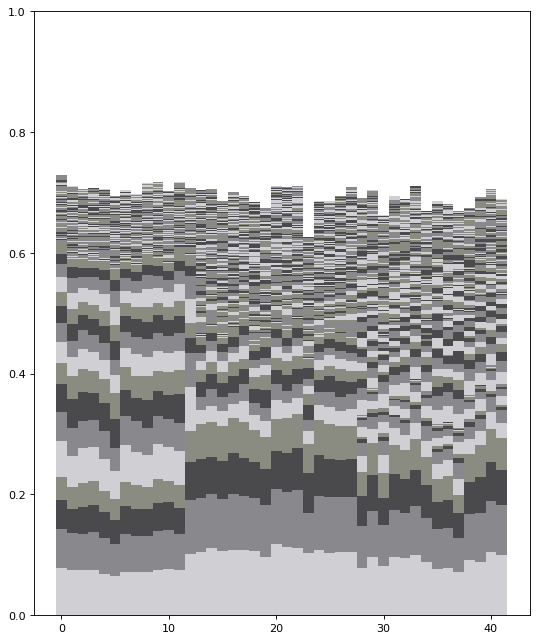

In [11]:
###### PLOTTING
# the greys for plotting
greyPalette = ['#D0CFD4', '#89888D', '#4A4A4C', '#8A8C82', '#D4D5D0', '#53544F']


# Set up plot
plt.figure(num=1, figsize=(8, 10), dpi=80)
ax = plt.subplot(1, 1, 1)
ax.set_ylim(bottom=0, top=1)

ind = range(len(sample_order_list))
width = 1

# Counters to work out which grey we are on
greyCounter = 0

# The bottom for each sequence plot will be updated each time we plot
bottom = [0 for smpl in sample_order_list]


# Only plot the first 250 seqs as this is the majority of the volume
# After that plot the rest of the volume as fixed height boxes
# NB the greyFileHeight should be the same as the max value (or not smaller) of the max random generated
greyFileHeight = 0.01
for i in range(len(sorted_rep_seq_list)):
    if i < 250:

        #print('Plotting seq {} out of {}'.format(i, len(sorted_rep_seq_list)))

        plotColour = greyPalette[greyCounter % 4]
        greyCounter += 1

        ax.bar(ind, plotting_info_holder_list[i], width, bottom=bottom, color=plotColour)
        bottom = [L + M for L, M in zip(bottom, plotting_info_holder_list[i])]
    # Change this back to a simple 'else' if you want to plot right the way through and get rid of the 
    # last else and break
    # for purposes of demonstrating what this script does I have limited this to printing 250 seqs
    #else:



#         #print('Plotting seq {} out of {}'.format(i, len(sorted_rep_seq_list)))
#         plotValuesList = []
#         for bValue in bottom:
#             if bValue < 100:
#                 # If this is not the last bar then plot a standard bar
#                 if bValue < 100 - greyFileHeight:
#                     plotValuesList.append(numpy.random.choice(numpy.arange(0.0001, 0.001, 0.0001),
#                                                               p=[0.1, 0.3, 0.3, 0.1, 0.1, 0.025, 0.025, 0.025,
#                                                                  0.025]))
#                 # If we're onto the last bar for the sample, take it up to 100
#                 elif bValue > 100 - greyFileHeight:
#                     plotValuesList.append(100 - bValue)
#             else:
#                 plotValuesList.append(0)
#         if sum(plotValuesList) == 0:
#             break
#         # now plot

#         plotColour = greyPalette[greyCounter % 4]
#         greyCounter += 1

#         ax.bar(ind, plotValuesList, width, bottom=bottom, color=plotColour)
#         bottom = [L + M for L, M in zip(bottom, plotValuesList)]
    else:
        break

# Here we should have it plotted and we'll just need to put the finishing touches to it.
# uncomment to save
#plt.savefig("/home/humebc/projects/SymPortalMS/fig_3_raw.svg")
plt.show()

#### 2. 'post QC and MED' figure

__Do imports__

In [12]:
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from Bio import SeqIO
import numpy
import pandas as pd

__Read in the list of DIVs__ (these will be coloured)

In [13]:
# read in the list that contains the DIVs that were used to create the ITS2 types.
# These will be coloured in the plot.
with open('/home/humebc/projects/SymPortalMS/significantSeqs', 'r') as f:
    significant_seqs_fasta_list = f.read().splitlines()

significant_seqs_list = []
for line in significant_seqs_fasta_list:
    if line.startswith('>'):
        significant_seqs_list.append(line[1:])

__Read in the SymPortal ITS2 output that will be used to plot as pandas DataFrame__

In [14]:
# we will use a SymPortal output to make the graph
# this will save us a lot of time.
# we will import this as a pandas dataframe
plotting_data_df = pd.read_csv('/home/humebc/projects/SymPortalMS/SP_output_for_figures/30_141.DIVs.absolute.txt',
                                delimiter='\t', header=0, index_col=0)

__Change index (row) order of the df to match that of the ordered sample list__

In [15]:
# now change the order of the index of the df according to the predefined order (same as raw plot)
# read in the sample list genreated previousy
with open('/home/humebc/projects/SymPortalMS/sample_order.txt') as f:
    sample_order_list = f.read().splitlines()

plotting_data_df = plotting_data_df.reindex(sample_order_list)

__Drop the columns that aren't going to be used for plotting__

In [16]:
# now drop the columns that contain the noName summaries and the QC info
# the first of the columns we want to drop
first_column_index = plotting_data_df.columns.get_loc("noName Clade A")
# last of the columns we want to drop
last_columnn_index = plotting_data_df.columns.get_loc("post_med_unique")
plotting_data_df.drop(plotting_data_df.columns[first_column_index:last_columnn_index + 1], axis=1, inplace=True)

# we also need to drop the colums that are not clade C seqs
index_to_drop = []
for seq_name in list(plotting_data_df):
    if 'C' not in seq_name:
        index_to_drop.append(plotting_data_df.columns.get_loc(seq_name))

plotting_data_df.drop(plotting_data_df.columns[index_to_drop], axis=1, inplace=True)

__Normalise the abundance of each sequence to that of the total sequence abundance for each sample__

In [19]:
# finally we need to normalise each of the seq abundances to the total seq abundances found in each sample
# i.e. divide each cell by the sum of its row
plotting_data_df = plotting_data_df.div(plotting_data_df.sum(axis=1), axis=0)

We can now use this plotting_data_df to plot from

__Assign a colour to each sequence; a unique colour if a DIV or grey if not__

In [20]:
# we can directly use the plotting_data_df for plotting
# we will go column by column when plotting
# therefore at this stage we have all of the info we need.
# we just need to work out which of the sub bars should be coloured and what colour they should be


# Colour palettes
colourPalette = ['#E8AB52', '#5FA96E', '#9680D3', '#D8C542', '#D47070', '#59A6D4', '#D76FBC', '#F6724C',
                 '#5FC2B6', '#80D1E4', '#6BD78A', '#B7D456']
greyPalette = ['#D0CFD4', '#89888D', '#4A4A4C', '#8A8C82', '#D4D5D0', '#53544F']

# create a seq to colour dictionary that we can use when plotting
seq_to_colour_dict = {}
colour_counter = 0
grey_counter = 0

# for each sequence
for sequence_to_plot in list(plotting_data_df):
    if sequence_to_plot in significant_seqs_list:
        seq_to_colour_dict[sequence_to_plot] = colourPalette[colour_counter]
        colour_counter += 1
    else:
        seq_to_colour_dict[sequence_to_plot] = greyPalette[grey_counter%6]
        grey_counter += 1

__Now plot column by column__

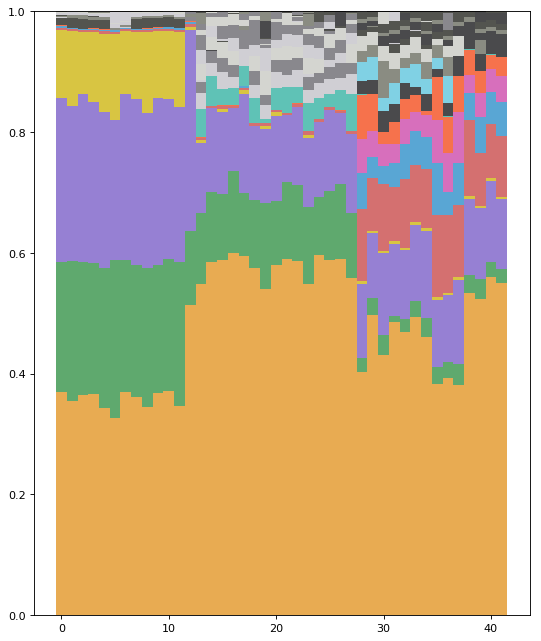

In [21]:
# we are now ready to plot
plt.figure(num=1, figsize=(8, 10), dpi=80)
ax = plt.subplot(1, 1, 1)
ax.set_ylim(bottom=0, top=1)

ind = range(len(sample_order_list))
width = 1

# The bottom for each sequence plot will be updated each time we plot
bottom = [0 for smpl in sample_order_list]


ordered_seq_list = list(plotting_data_df)
for i in range(len(ordered_seq_list)):
    seq_name_in_Q = ordered_seq_list[i]
    # print('Plotting seq {} out of {}'.format(i, len(ordered_seq_list)))
    ax.bar(ind, plotting_data_df[seq_name_in_Q], width, bottom=bottom, color=seq_to_colour_dict[seq_name_in_Q])
    bottom = [L + M for L, M in zip(bottom, plotting_data_df[seq_name_in_Q])]


# Here we should have it plotted and we'll just need to put the finishing touches to it.
# plt.savefig("/home/humebc/projects/SymPortalMS/fig_3_colour_090718.svg")
plt.show()

#### 3 . psbAncr phylogenetic tree

I originally worked directly with the psbAncr sequences that were submitted to the dryad repository that was associated with the Smith et al metahaplotype paper. I made a tree from these sequences. Whilst this tree sepearted the three species of host perfectly I feel that there might be more resolution available from the data. So... I am going back to the original fastq files and working with the psbAncr sequences myself to see how much info there is to be had and specifically whether I can get a better resolving tree.